### [당뇨병 발병 원인]
당뇨병 발생을 예측하기 위해 랜덤포레스트 분석을 실시하고 결과를 해석하시오.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

#### 1.데이터 구성하기

In [2]:
df_raw = pd.read_csv('/home/pirl/Downloads/data2_py/DIABETES.csv')
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [3]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['Y']
df_raw_x = df_raw.drop('Y',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


In [4]:
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#회귀분석
from statsmodels.formula.api import ols
#qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot,add_constant
#선형모델
import statsmodels.formula.api as smf

In [5]:
df_raw_x = df_raw.drop('Y', axis=1)

df_raw_x_const = add_constant(df_raw_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,AGE,1.217
2,GENDER,1.278
4,BP,1.459
10,GLUCOSE,1.485
3,BMI,1.509
8,TCH,8.891
9,LTG,10.076
7,HDL,15.402
6,LDL,39.193
5,CHOLESTEROL,59.203


다중공선성 VIF값이 높은 CHOLESTEROL 을 먼저 제거해본다.

In [6]:
df_raw_x = df_raw.drop(['Y','CHOLESTEROL','GENDER'], axis=1)

df_raw_x_const = add_constant(df_raw_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,AGE,1.205
3,BP,1.406
2,BMI,1.473
8,GLUCOSE,1.476
7,LTG,2.147
4,LDL,2.926
5,HDL,3.616
6,TCH,7.783
0,const,200.278


#### 2. 모델 생성

In [7]:
#기본 옵션으로 트리 생성
rf_uncustomized = RandomForestRegressor(random_state=241)
rf_uncustomized.fit(df_train_x,df_train_y)

print('Score on training set:{:.3f}'.format(rf_uncustomized.score(df_train_x,df_train_y)))
print('Score on test set:{:.3f}'.format(rf_uncustomized.score(df_test_x,df_test_y)))

Score on training set:0.906
Score on test set:0.260


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
#모델 parameter 조정 : 트리 수 변경에 따른 모델 성능

#train , test 설명력 결과 저장
train_score=[]; test_score=[]
para_n_tree=[n_tree * 10 for n_tree in range(1,12)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators, random_state=1)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators']=para_n_tree
df_score_n['TrainScore']=train_score
df_score_n['TestScore']=test_score

In [9]:
#모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.895,0.330
1,20,0.910,0.342
2,30,0.917,0.335
3,40,0.919,0.347
4,50,0.922,0.341
5,60,0.922,0.340
6,70,0.922,0.338
7,80,0.923,0.342
8,90,0.924,0.345
9,100,0.924,0.350


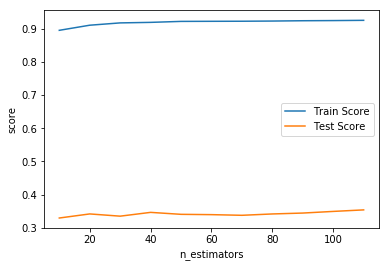

In [10]:
#모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle='-', label='Train Score')
plt.plot(para_n_tree, test_score, linestyle='-', label='Test Score')
plt.ylabel('score');plt.xlabel('n_estimators')
plt.legend()

In [11]:
#모델 parameter 조정 : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

#train, test의 설명력 결과 저장
train_score=[];test_score=[]

#min_samples_leaf : 잎사귀 최소 자료 수
para_leaf =[n_leaf * 1 for n_leaf in range(1,31)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1,n_estimators=80,
                                min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

#데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [12]:
#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.923,0.342
1,2,0.890,0.333
2,3,0.842,0.343
3,4,0.802,0.362
4,5,0.767,0.370
5,6,0.735,0.369
6,7,0.711,0.371
7,8,0.692,0.371
8,9,0.675,0.367
9,10,0.662,0.370


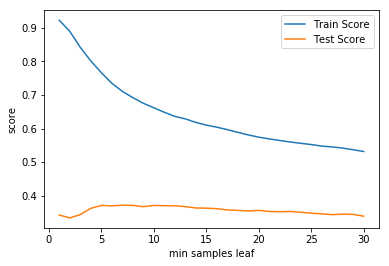

In [13]:
#모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')
plt.plot(para_leaf, test_score, linestyle='-', label='Test Score')
plt.ylabel('score');plt.xlabel('min samples leaf')
plt.legend()

In [14]:
#모델 parameter 조정 : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

#train, test의 설명력 결과 저장
train_score=[];test_score=[]

#min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split =[n_split * 1 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=123,n_estimators=80,
                                min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

#데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesLeaf'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [15]:
#모델 설명력 확인
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,2,0.920,0.356
1,3,0.915,0.355
2,4,0.906,0.351
3,5,0.894,0.349
4,6,0.882,0.351
5,7,0.869,0.354
6,8,0.856,0.352
7,9,0.843,0.349
8,10,0.830,0.355
9,11,0.818,0.359


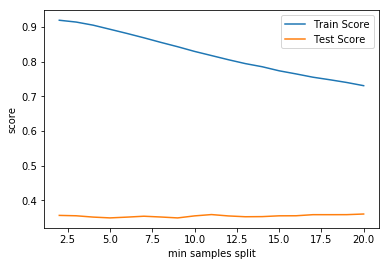

In [16]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, test_score, linestyle='-', label='Test Score')
plt.ylabel('score');plt.xlabel('min samples split')
plt.legend()

In [17]:
#모델 parameter 조정 : 최대 깊이 변경에 따른 모델 성능

#train, test의 설명력 결과 저장
train_score=[];test_score=[]

#max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=123,n_estimators=80,
                                min_samples_leaf=5, min_samples_split=8,
                                max_depth = v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

#데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth['MinSamplesLeaf'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [18]:
#모델 설명력 확인
df_score_depth.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.418,0.277
1,2,0.531,0.340
2,3,0.609,0.357
3,4,0.675,0.365
4,5,0.726,0.365
5,6,0.750,0.364
6,7,0.764,0.365
7,8,0.767,0.363
8,9,0.768,0.363
9,10,0.768,0.363


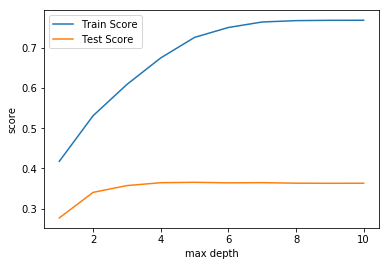

In [19]:
#모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, test_score, linestyle='-', label='Test Score')
plt.ylabel('score'); plt.xlabel('max depth')
plt.legend()

### 3. 결론 도출

In [20]:
rf_final=RandomForestRegressor(random_state=123,n_estimators=80, min_samples_leaf=5,
                              min_samples_split=8, max_depth=3)
rf_final.fit(df_train_x, df_train_y)
print('Score on training set:{:.3f}'.format(rf_final.score(df_train_x,df_train_y)))
print('Score on test set:{:.3f}'.format(rf_final.score(df_test_x,df_test_y)))
rf_final

Score on training set:0.609
Score on test set:0.357


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False)